In [1]:
import os
import numpy as np
import pandas as pd
import Bio as bp
import Levenshtein as lev # requires 'pip install python-Levenshtein'
import matplotlib.pyplot as plt

# get training and test data
train_df = pd.read_csv('../train_input.csv')
test_df = pd.read_csv('../test_input.csv')

In [2]:
# aa and q8 sequences
aa_tr, q8_tr = train_df[['sequence', 'q8']].values.T
aa_te, q8_te = test_df[['sequence', 'q8']].values.T

# load the training targets for pasting matches
maxlen_seq = max(train_df['length'].values.max(), test_df['length'].values.max())
train_target_arrs = np.load('../train_output.npz')
seq_len = train_df['length'].values
train_target_data = np.zeros((len(train_df), maxlen_seq, maxlen_seq))
for i in range(len(train_df)):
    train_target_data[i, :seq_len[i], :seq_len[i]] = train_target_arrs['arr_' + str(i)]

In [3]:
# amino acid database 
with open('aa_db.fasta', 'w+') as out:
    for i in range(len(aa_tr)):
        out.write('>' + str(i) + '\n' + aa_tr[i] + '\n')
# and query list        
with open('aa_query.fasta', 'w+') as out:
    for i in range(len(aa_te)):
        out.write('>' + str(i) + '\n' + aa_te[i] + '\n')
        
# In the command line run:
# makeblastdb -in aa_db.fasta -dbtype prot -out aadb 
# blastp -db aadb -query aa_query.fasta -out aa_match.txt
# in order to set up the local database and find matches in AA
# tried running these through os.system('[call]') but returned error
#     (probably a python2 problem lmao)

In [ ]:
# q8 database 
with open('q8_db.fasta', 'w+') as out:
    for i in range(len(q8_tr)):
        seq = '>' + str(i) + '\n' + q8_tr[i] + '\n'
        seq = seq.replace('B', 'C') ## B is not a valid character in BLAST, so use a substitution
        out.write('>' + str(i) + '\n' + q8_tr[i] + '\n')
# and query list        
with open('q8_query.fasta', 'w+') as out:
    for i in range(len(q8_te)):
        seq = '>' + str(i) + '\n' + q8_te[i] + '\n'
        seq = seq.replace('B', 'C') ## B is not a valid character in BLAST, so use a substitution
        out.write('>' + str(i) + '\n' + q8_te[i] + '\n')
        
# In the command line run:
# makeblastdb -in q8_db.fasta -dbtype prot -out q8db 
# blastp -db q8db -query q8_query.fasta -out q8_match.txt
# in order to set up the local database and find matches in Q8
# this blast search takes much longer to run

In [11]:
''' 
- reads in matches from blast outfile
- alignments[i] will contain matches of query_i in the training set
- the matches are an array of size num_matches x 5
- each match has form (query_idx_start, query_idx_end, match, match_idx_start, match_idx end)
'''
def get_alignments(match_file):
    alignments = {}
    query_alignments = None
    with open(match_file, 'r') as f:
        line = f.readline()
        while line:
            # matches for one query
            if 'Query=' in line:
                if query_alignments: # dump the alignments from the previous query
                    alignments[query] = np.array(query_alignments)
                query = int(line.split(' ')[-1]) # get the new query number
                query_alignments = [] # reset alignments
            # record a training sequence that has match(es) with the query
            elif '>' in line: # get matching sequence
                match = int(line.split(' ')[-1])
            # record the indices of the match
            elif 'Query ' in line: # get the alignment
                q = list(filter(None, line.split(' '))) # start idx is 1, end idx is -1
                f.readline(); line = f.readline()
                m = list(filter(None, line.split(' '))) # start idx is 1, end idx is -1
                align = [int(q[1])-1, int(q[-1]), match, int(m[1])-1, int(m[-1])]
                query_alignments.append(align)
            line = f.readline()
        alignments[query] = np.array(query_alignments) # dump final query alignments
    return alignments

In [31]:
'''
-Takes matches in the aa or q8 sequences
-If the levenshtein distance between them is in fact relatively small, 
    save the corresponding inter-residue distances 
'''
def get_stitches(alignments):
    stitches = np.zeros((len(test_df), maxlen_seq, maxlen_seq))
    seq_len = test_df['length'].values

    for i in range(len(test_df)):
        if i not in alignments.keys(): # matches not found for all sequences
            continue
        al = alignments[i] # load up the alignments for the current test ex
        good_als = []
        lev_dists = []
        for a in al:
            query_q8 = q8_te[0][a[0]:a[1]]
            match_q8 = q8_tr[a[2]][a[3]:a[4]]
            length = a[1] - a[0]
            d = lev.distance(query_q8, match_q8) # compare the q8 segments corresponding to this match
            if d > length/2.: # skip matches with large q8 distances; consider removing this; will test when GAN is trained
                continue
            good_als.append(a)
            lev_dists.append(d)

        # sort the good matches by the Levenshtein difference of q8
        lev_dists = np.array(lev_dists)
        ordered_a = np.argsort(-lev_dists)

        # that way best matches are pasted over the top
        for idx in ordered_a:
            a = good_als[idx]
            length = a[1] - a[0]
            stitches[i, a[0]:a[1], a[0]:a[1]] = train_target_data[a[2], a[3]:a[3]+length, a[3]:a[3]+length]
    return stitches

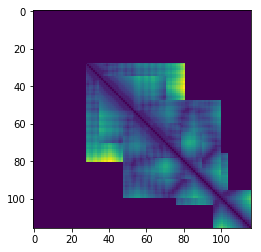

In [41]:
alignments_aa = get_alignments('aa_match.txt')
stitches_aa = get_stitches(alignments_aa)
# example:
plt.imshow(((255/stitches_aa[0].max()) * stitches_aa[0])[:116,:116], aspect=1)

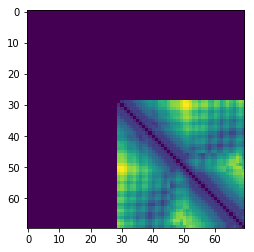

In [42]:
alignments_q8 = get_alignments('q8_match.txt')
stitches_q8 = get_stitches(alignments_q8)
# example:
plt.imshow(((255/stitches_q8[16].max()) * stitches_q8[213])[:70,:70], aspect=1)

In [47]:
# Note that all but three queries produced matches. However, it remains to be quantified 
# how many matches in the aa sequence lead to good matches in the q8 segments. 
# doing so might be a good metric to guage how the utility of this approach
len(alignments_aa)

221

In [48]:
# It should be noted that very few queries between q8 sequences had matches let alone good ones
len(alignments_q8)
# It is very unclear to me why this should be the case, and I cannot help but feel the BLAST function
# is optimized assuming amino acid character names, hence the lack of matches that are returned despite knowing
# that many exist, given outputs of aa matches

17

The behavior of the Q8 matches as outlined above is unexpected and needs thorough investigation. Let me know if you disagree.

Another thing, this method is slightly limiting because it can only copy distances into squares about the diagonal. One thing that should definitely be looked into is constructing the Q8 matrices that Iddo showed us. Perhaps this will allow us to paste squares elsewhere in matrix.

A final point, perhaps you can write an additional function which takes matches from aa and q8 and copies the distances corresponding to all good matches from both sets. It would also be interesting to see if there is overlap etc.